# QQQ Analysis

For this notebook we will make an analysis to answer the following question: Does investing in the QQQ now will give low risk profit over the period of 1 year?

In this matter we will try to analyze the QQQ and its peers and how to maximize the returns over a capital of 1000$.

## Set Parameters

- Period: 1 year
- Capital: 1000$
- Risk: Low
- Derevatives: Options, Futures

In [114]:
# Getting all the necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from scipy.stats import jarque_bera, skew, kurtosis, norm

In [2]:
TRADING_DAYS = 252

## Basic Portafolio

Since the capital is small, diversification is also a problem, in that matter the best idea is to hedge the position using slightly OTM Calls to hedge the position. For this manner we will need the historical data for QQQ, VOO, and IWM and test which ones can give the best returns. We will get the last 3 years data to compare the 3 ETFs.

In [3]:
qqq = yf.download('QQQ', period='3y', interval='1d')
voo = yf.download('VOO', period='3y', interval='1d')
iwm = yf.download('IWM', period='3y', interval='1d')

/tmp/ipython-input-1018038540.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  qqq = yf.download('QQQ', period='3y', interval='1d')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1018038540.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  voo = yf.download('VOO', period='3y', interval='1d')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1018038540.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  iwm = yf.download('IWM', period='3y', interval='1d')
[*********************100%***********************]  1 of 1 completed


In [4]:
qqq.head(10)

Price,Close,High,Low,Open,Volume
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ
Date,,,,,
2022-08-22,308.255524,312.550475,307.441654,312.315145,51098900
2022-08-23,308.000580,310.844260,307.245513,308.020181,39497100
2022-08-24,308.892883,310.716750,306.912090,307.520046,38057100
2022-08-25,314.354706,314.374337,309.628327,310.677526,38098300
2022-08-26,301.469879,315.266663,301.381630,314.060538,69047700
2022-08-29,298.498688,301.254118,297.390626,298.704601,48321900
2022-08-30,295.174622,300.773763,292.644735,300.155992,51184500
2022-08-31,293.458557,298.989050,293.350708,298.086902,50044000


In [5]:
voo.head(10)

Price,Close,High,Low,Open,Volume
Ticker,VOO,VOO,VOO,VOO,VOO
Date,,,,,
2022-08-22,363.318787,366.761303,362.505966,366.656100,4153700
2022-08-23,362.458099,365.164282,361.960829,362.955340,2869200
2022-08-24,363.557800,364.886977,361.635723,362.324226,2241200
2022-08-25,368.855469,368.855469,364.045517,365.059143,2631300
2022-08-26,356.213776,369.161419,356.213776,368.683292,5153200
2022-08-29,353.861389,356.730148,352.646958,353.593640,4953200
2022-08-30,350.017273,355.200177,348.095195,355.056716,5044500
2022-08-31,347.263214,352.656494,347.224956,351.528094,4062500


In [6]:
iwm.head(10)

Price,Close,High,Low,Open,Volume
Ticker,IWM,IWM,IWM,IWM,IWM
Date,,,,,
2022-08-22,182.935913,184.576816,182.331368,184.231363,22937000
2022-08-23,183.233398,185.133379,182.696031,183.223808,20069800
2022-08-24,184.634415,185.488448,182.475341,183.079871,16038300
2022-08-25,187.503571,187.551553,185.181368,185.565212,14795000
2022-08-26,181.342987,187.541934,181.035926,187.445969,24177200
2022-08-29,179.673355,181.352635,178.982450,179.395066,19753300
2022-08-30,177.159195,180.412199,176.122838,180.229889,22548900
2022-08-31,176.084457,178.233941,175.786987,177.466267,22412500


In [7]:
# Renaming columns
qqq.columns = ['close', 'high', 'low', 'open', 'volume']
voo.columns = ['close', 'high', 'low', 'open', 'volume']
iwm.columns = ['close', 'high', 'low', 'open', 'volume']

In [8]:
# Reset indexes
qqq.reset_index(inplace=True)
voo.reset_index(inplace=True)
iwm.reset_index(inplace=True)

In [9]:
qqq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    752 non-null    datetime64[ns]
 1   close   752 non-null    float64       
 2   high    752 non-null    float64       
 3   low     752 non-null    float64       
 4   open    752 non-null    float64       
 5   volume  752 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 35.4 KB


In [10]:
voo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    752 non-null    datetime64[ns]
 1   close   752 non-null    float64       
 2   high    752 non-null    float64       
 3   low     752 non-null    float64       
 4   open    752 non-null    float64       
 5   volume  752 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 35.4 KB


In [11]:
iwm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    752 non-null    datetime64[ns]
 1   close   752 non-null    float64       
 2   high    752 non-null    float64       
 3   low     752 non-null    float64       
 4   open    752 non-null    float64       
 5   volume  752 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 35.4 KB


In [12]:
qqq.describe()

,Date,close,high,low,open,volume
count,752,752.000000,752.000000,752.000000,752.000000,7.520000e+02
mean,2024-02-19 03:26:48.510638336,410.617826,413.477562,407.367971,410.519324,4.643836e+07
min,2022-08-22 00:00:00,255.890594,259.829801,249.770644,250.654763,1.533400e+07
25%,2023-05-21 06:00:00,331.096123,332.733240,328.041314,330.183884,3.517525e+07
50%,2024-02-20 12:00:00,423.565247,426.843664,420.922873,424.175718,4.511370e+07
75%,2024-11-15 18:00:00,485.293373,488.430438,482.226285,485.431495,5.529910e+07
max,2025-08-20 00:00:00,580.340027,583.320007,578.940002,582.760010,1.615570e+08
std,NaN,90.195298,90.376971,89.890342,90.300964,1.650918e+07


In [13]:
voo.describe()

,Date,close,high,low,open,volume
count,752,752.000000,752.000000,752.000000,752.000000,7.520000e+02
mean,2024-02-19 03:26:48.510638336,446.844972,449.138166,444.181680,446.741283,5.205553e+06
min,2022-08-22 00:00:00,314.685089,317.508814,307.222229,308.153876,1.351300e+06
25%,2023-05-21 06:00:00,369.884697,371.909394,368.106529,369.887130,3.561575e+06
50%,2024-02-20 12:00:00,451.497711,452.877449,448.186078,450.049143,4.499550e+06
75%,2024-11-15 18:00:00,517.746887,520.459449,515.215704,518.208044,5.821525e+06
max,2025-08-20 00:00:00,592.849976,594.030029,590.809998,593.859985,3.541800e+07
std,NaN,78.215506,78.242633,78.054551,78.244532,3.274931e+06


In [14]:
iwm.describe()

,Date,close,high,low,open,volume
count,752,752.000000,752.000000,752.000000,752.000000,7.520000e+02
mean,2024-02-19 03:26:48.510638336,194.469967,196.090236,192.823570,194.519045,3.125527e+07
min,2022-08-22 00:00:00,158.350540,161.488829,156.739711,158.186539,1.164770e+07
25%,2023-05-21 06:00:00,176.394810,178.430878,175.094035,176.387648,2.300080e+07
50%,2024-02-20 12:00:00,193.141624,194.955936,191.471071,193.377661,2.830695e+07
75%,2024-11-15 18:00:00,210.618263,212.089778,209.389329,210.559613,3.613745e+07
max,2025-08-20 00:00:00,240.476379,243.035907,239.623194,240.446609,1.230151e+08
std,NaN,20.236736,20.265183,20.244707,20.319415,1.250498e+07


## EDA for the 3 Assets

In this part of the notebook we will take a look at the 3 assets and look for patterns inside our data, then we will use pricing models to derive conclusion from this data and simulate possible scenerios between this investing time.

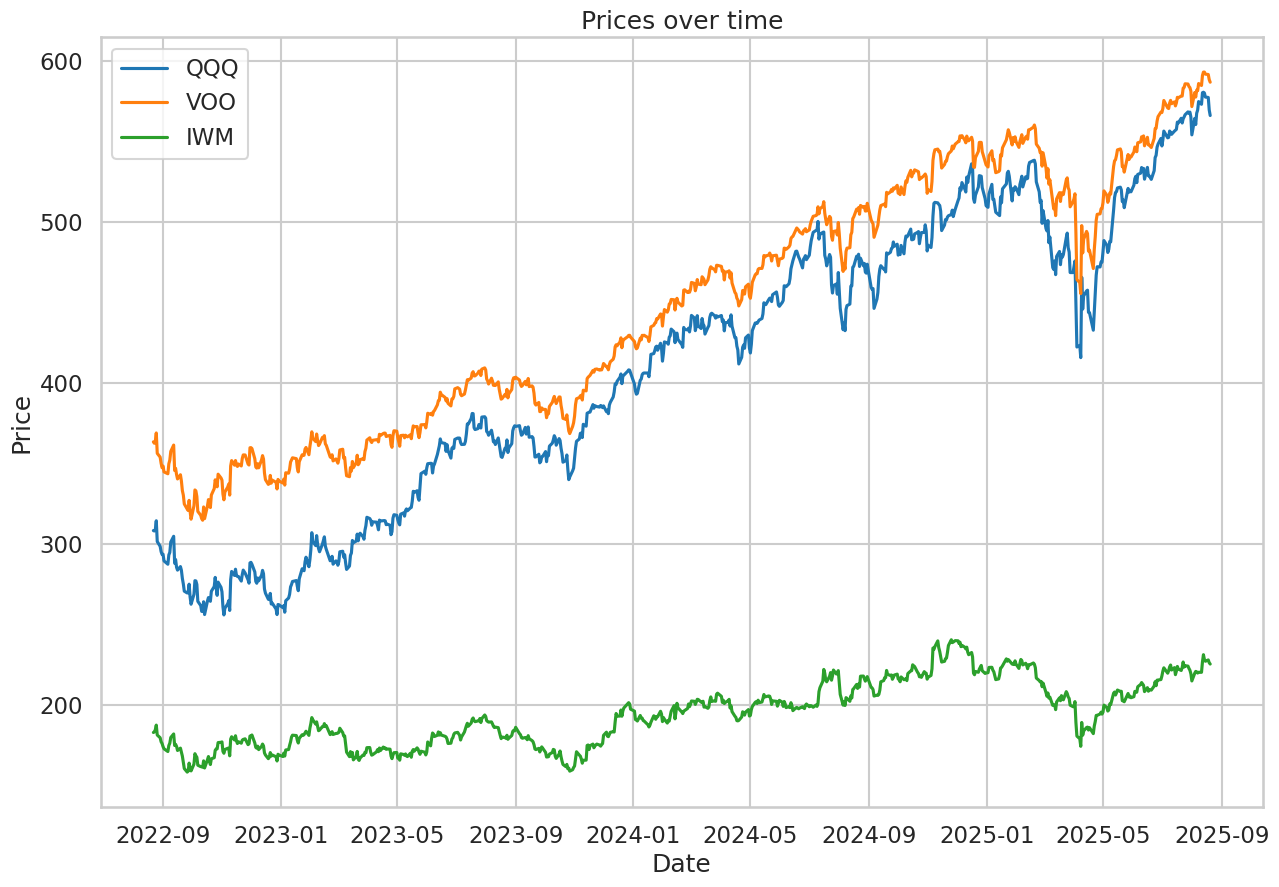

In [15]:
# Plotting prices over time with seaborn
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(15, 10))
sns.lineplot(x='Date', y='close', data=qqq, label='QQQ')
sns.lineplot(x='Date', y='close', data=voo, label='VOO')
sns.lineplot(x='Date', y='close', data=iwm, label='IWM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Prices over time')
plt.show()

In [16]:
# Getting returns
qqq['returns'] = qqq['close'].pct_change()
voo['returns'] = voo['close'].pct_change()
iwm['returns'] = iwm['close'].pct_change()

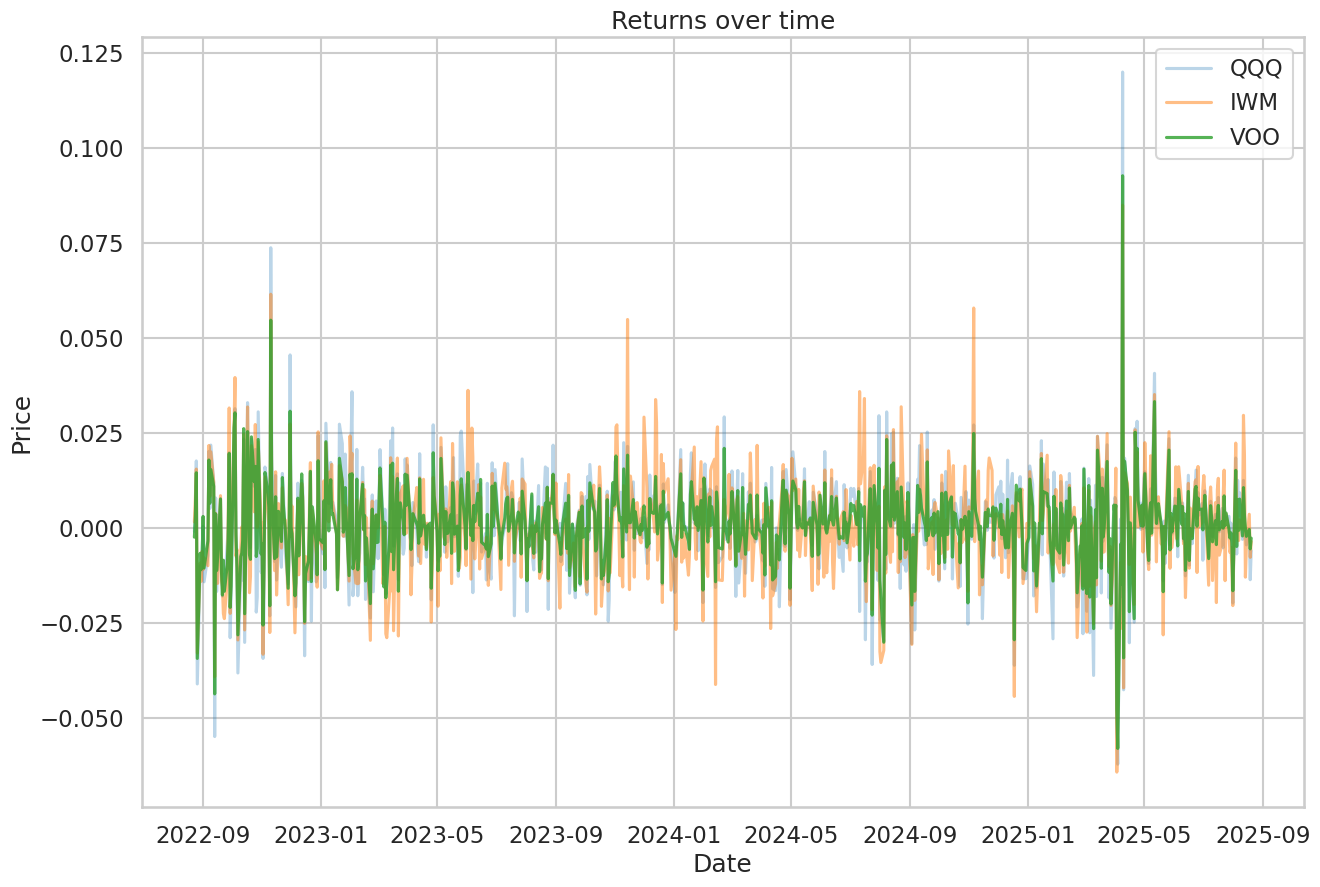

In [17]:
# Plotting returns from stocks
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(15, 10))
sns.lineplot(x='Date', y='returns', data=qqq, label='QQQ', alpha=0.3)
sns.lineplot(x='Date', y='returns', data=iwm, label='IWM', alpha=0.5)
sns.lineplot(x='Date', y='returns', data=voo, label='VOO', alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Returns over time')
plt.show()

In [18]:
# Get log returns
qqq['log_returns'] = np.log(qqq['close'] / qqq['close'].shift(1))
voo['log_returns'] = np.log(voo['close'] / voo['close'].shift(1))
iwm['log_returns'] = np.log(iwm['close'] / iwm['close'].shift(1))

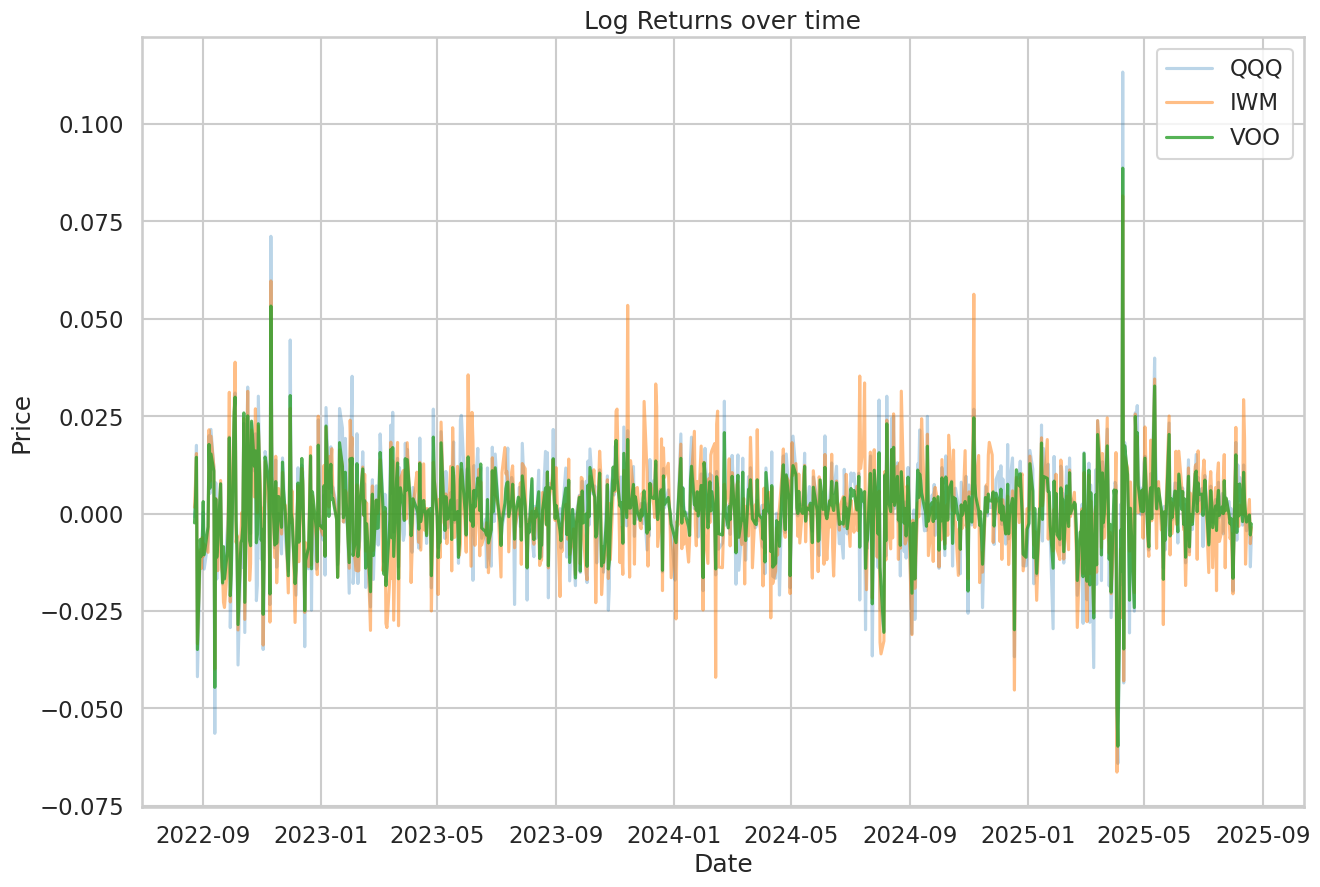

In [19]:
# Plotting log returns
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(15, 10))
sns.lineplot(x='Date', y='log_returns', data=qqq, label='QQQ', alpha=0.3)
sns.lineplot(x='Date', y='log_returns', data=iwm, label='IWM', alpha=0.5)
sns.lineplot(x='Date', y='log_returns', data=voo, label='VOO', alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Log Returns over time')
plt.show()

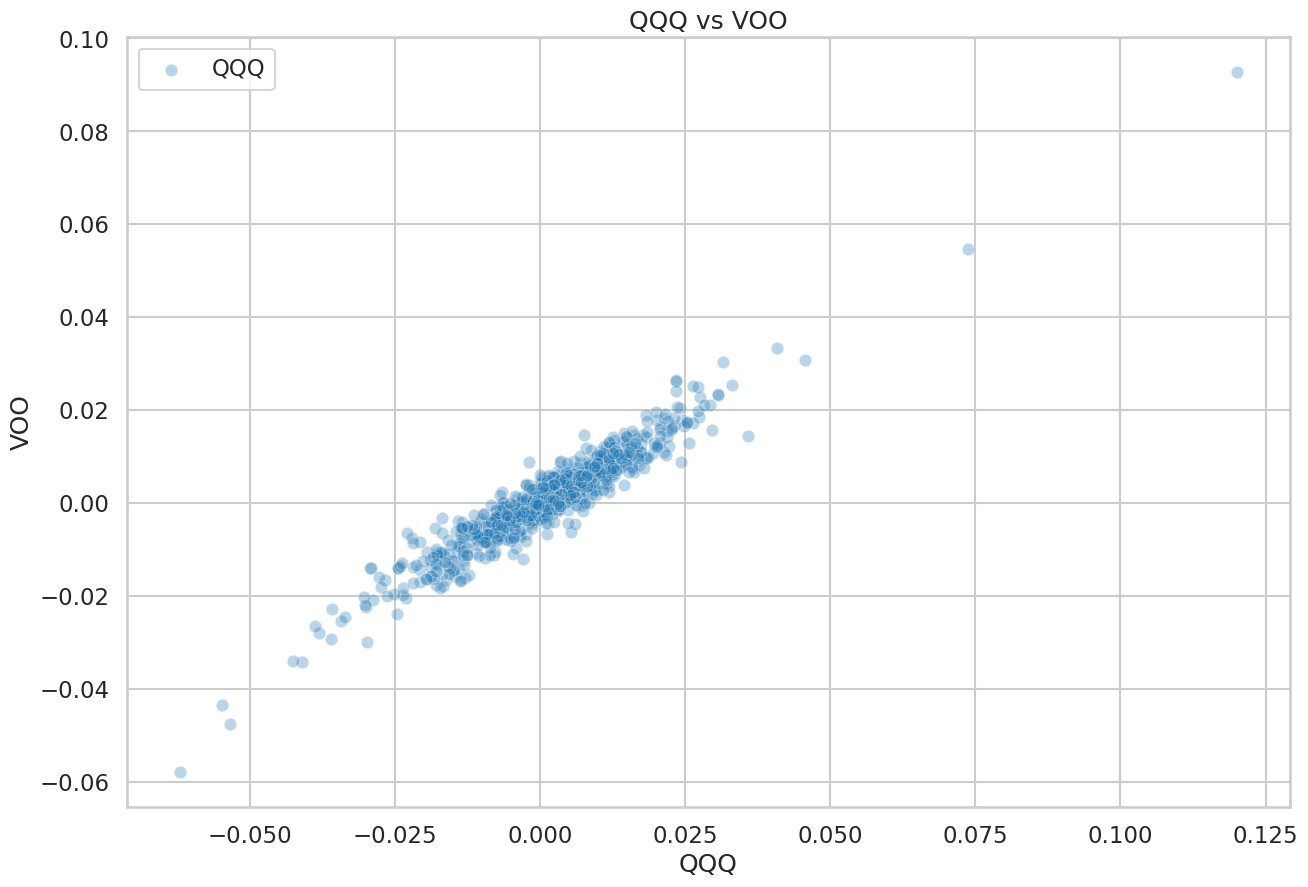

In [20]:
## Lookint at the correlation between QQQ and VOO as a Seaborn scatter plot
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(15, 10))
sns.scatterplot(x=qqq['returns'], y=voo['returns'], label='QQQ', alpha=0.3)
plt.xlabel('QQQ')
plt.ylabel('VOO')
plt.legend()
plt.title('QQQ vs VOO')
plt.show()


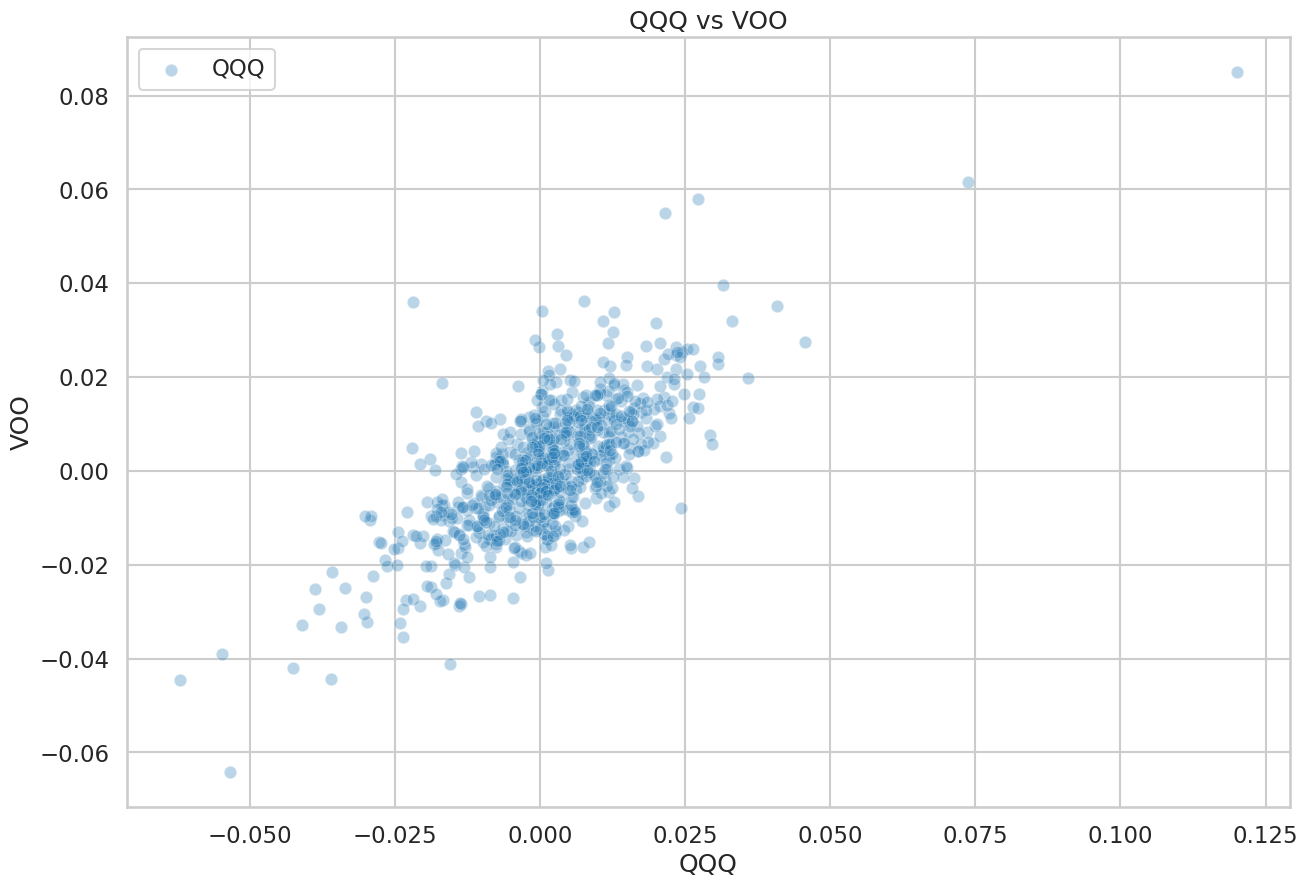

In [21]:
## Lookint at the correlation between QQQ and IWM as a Seaborn scatter plot
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(15, 10))
sns.scatterplot(x=qqq['returns'], y=iwm['returns'], label='QQQ', alpha=0.3)
plt.xlabel('QQQ')
plt.ylabel('VOO')
plt.legend()
plt.title('QQQ vs VOO')
plt.show()

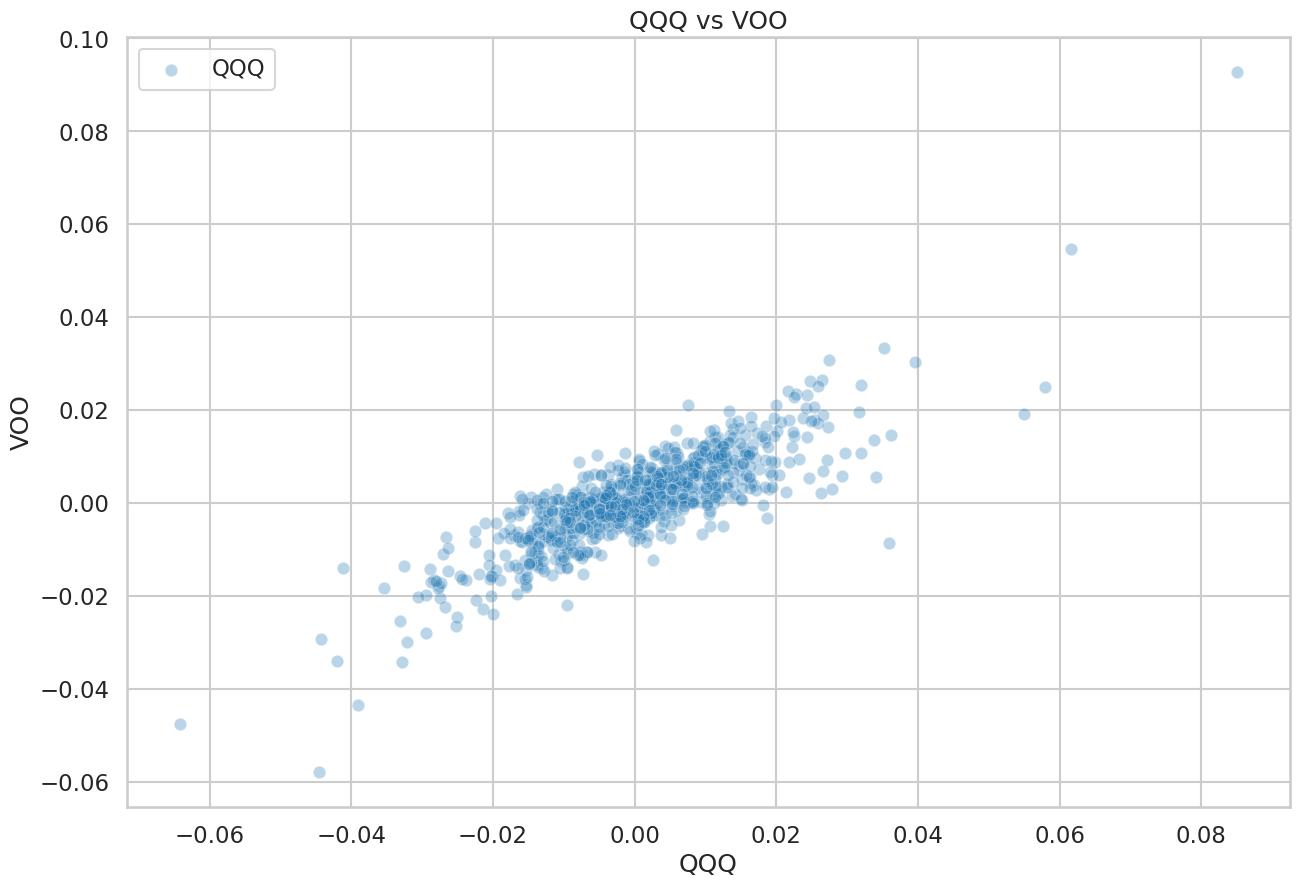

In [22]:
## Lookint at the correlation between IWM and VOO as a Seaborn scatter plot
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(15, 10))
sns.scatterplot(x=iwm['returns'], y=voo['returns'], label='QQQ', alpha=0.3)
plt.xlabel('QQQ')
plt.ylabel('VOO')
plt.legend()
plt.title('QQQ vs VOO')
plt.show()

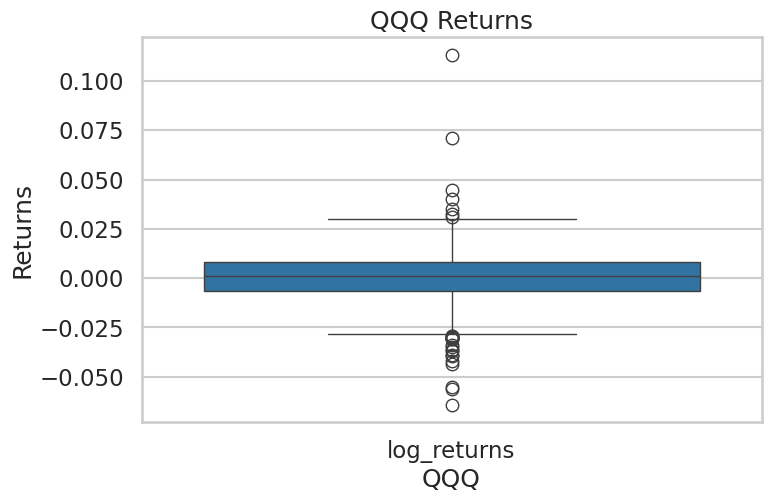

In [23]:
# Looking at the plotbox for the returns
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(8, 5))
sns.boxplot(data=qqq[['log_returns']])
plt.xlabel('QQQ')
plt.ylabel('Returns')
plt.title('QQQ Returns')
plt.show()

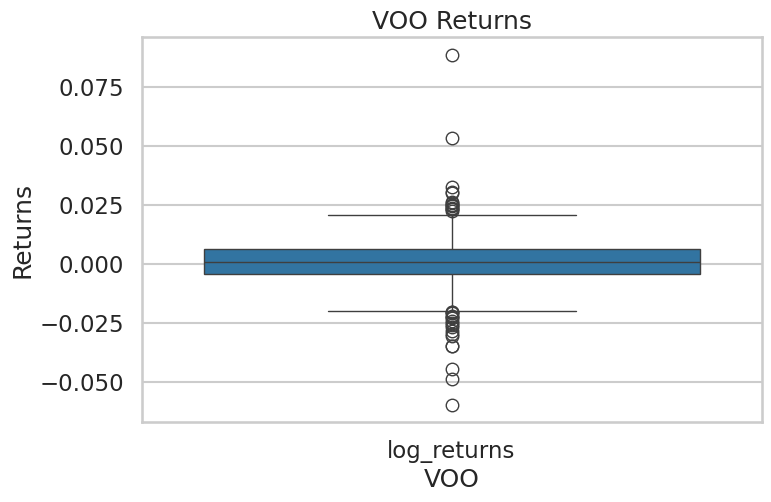

In [24]:
# Looking at the plotbox for the returns
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(8, 5))
sns.boxplot(data=voo[['log_returns']])
plt.xlabel('VOO')
plt.ylabel('Returns')
plt.title('VOO Returns')
plt.show()

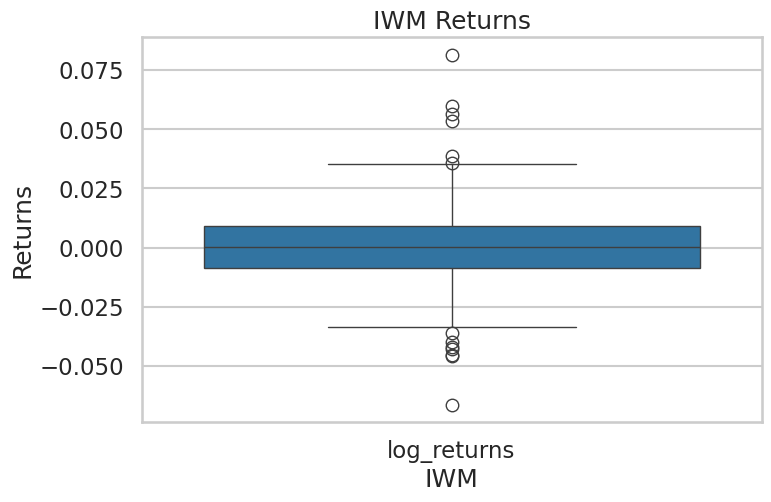

In [25]:
# Looking at the plotbox for the returns
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(8, 5))
sns.boxplot(data=iwm[['log_returns']])
plt.xlabel('IWM')
plt.ylabel('Returns')
plt.title('IWM Returns')
plt.show()

## Getting Basic Statistics

For this part we will get some basic statistics values to compare from the returns of the 3 stocks.

In [26]:
def to_simple_returns(s, kind="simple"):
    """
    s: pd.Series of returns (simple or log)
    kind: "simple" if s is already simple returns; "log" if s is log-returns
    """
    if kind == "simple":
        return s.dropna()
    elif kind == "log":
        return (np.exp(s) - 1).dropna()
    else:
        raise ValueError("kind must be 'simple' or 'log'")

In [27]:
def annualized_drift_from_log(log_ret: pd.Series) -> float:
    """
    GBM-consistent drift: mu ≈ mean(log_ret) * 252 + 0.5 * var(log_ret) * 252
    (use this if you model with log returns)
    """
    m = log_ret.dropna().mean()
    v = log_ret.dropna().var(ddof=1)
    return m * TRADING_DAYS + 0.5 * v * TRADING_DAYS

In [28]:
def annualized_return_from_simple(R: pd.Series) -> float:
    """
    Compound annual growth rate (CAGR) from simple daily returns.
    """
    R = R.dropna()
    if R.empty:
        return np.nan
    gross = (1 + R).prod()
    n_years = len(R) / TRADING_DAYS
    return gross**(1 / n_years) - 1

In [29]:
def annualized_vol(R: pd.Series) -> float:
    return R.dropna().std(ddof=1) * np.sqrt(TRADING_DAYS)

In [30]:
def sharpe_ratio(R: pd.Series, rf_daily: float = 0.0) -> float:
    """
    Sharpe using simple daily returns and a daily risk‑free rate.
    rf_daily can be scalar or same-index Series.
    """
    R = R.dropna()
    if np.isscalar(rf_daily):
        excess = R - rf_daily
    else:
        excess = (R - rf_daily.reindex_like(R)).dropna()
    mu = excess.mean() * TRADING_DAYS
    sig = excess.std(ddof=1) * np.sqrt(TRADING_DAYS)
    return mu / sig if sig > 0 else np.nan

In [31]:
def sortino_ratio(R: pd.Series, rf_daily: float = 0.0) -> float:
    """
    Sortino with 0 (or rf) as the target; downside deviation annualized.
    """
    R = R.dropna()
    if np.isscalar(rf_daily):
        excess = R - rf_daily
    else:
        excess = (R - rf_daily.reindex_like(R)).dropna()
    downside = excess[excess < 0]
    dd = downside.std(ddof=1) * np.sqrt(TRADING_DAYS)  # downside deviation (annualized)
    mu = excess.mean() * TRADING_DAYS
    return mu / dd if dd > 0 else np.nan

In [32]:
def skew_kurtosis(R: pd.Series):
    """
    Pandas skew() uses Fisher’s definition for skewness.
    kurtosis() in pandas returns Fisher’s excess kurtosis by default (normal=0).
    """
    R = R.dropna()
    return R.skew(), R.kurtosis()

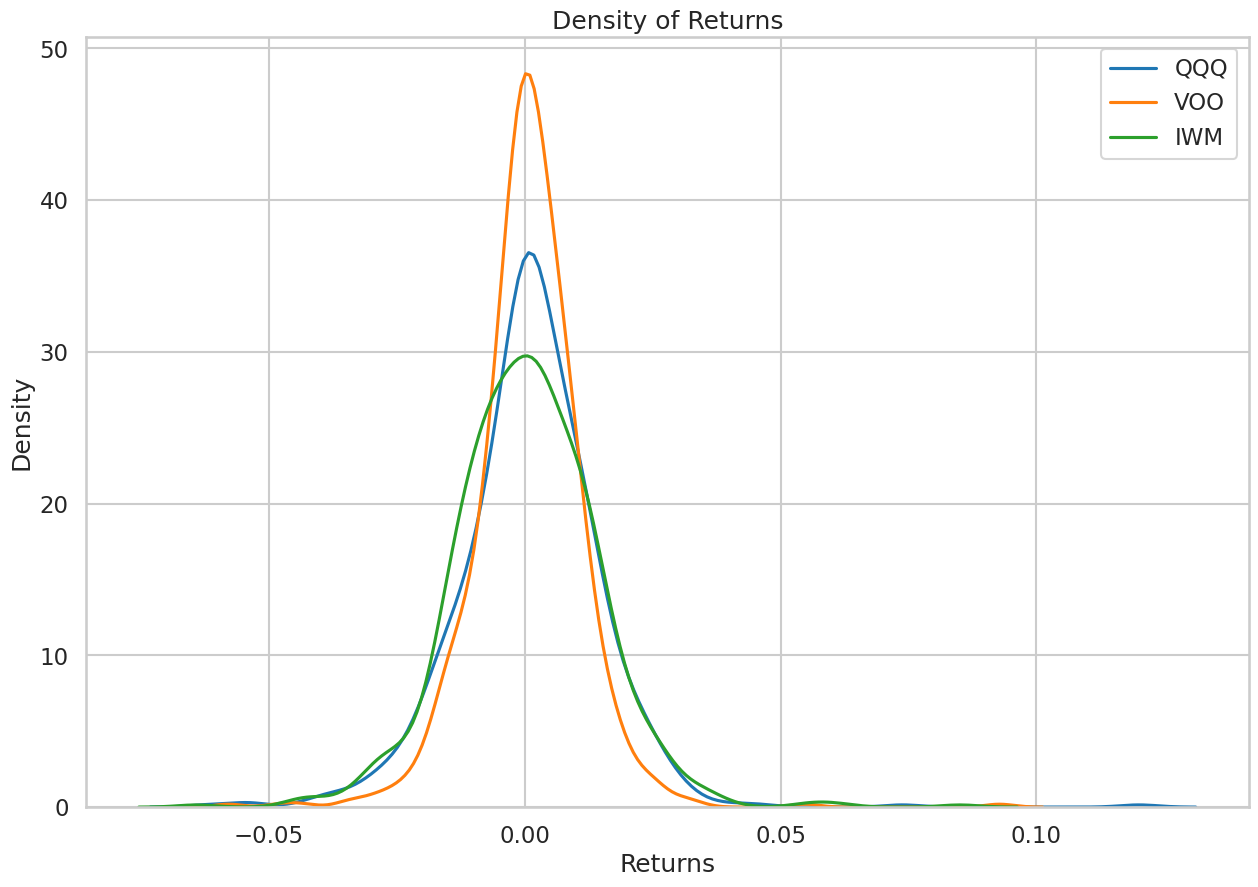

In [33]:
# Looking at he KDE of the returns
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(15, 10))
sns.kdeplot(qqq['returns'], label='QQQ')
sns.kdeplot(voo['returns'], label='VOO')
sns.kdeplot(iwm['returns'], label='IWM')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.title('Density of Returns')
plt.show()

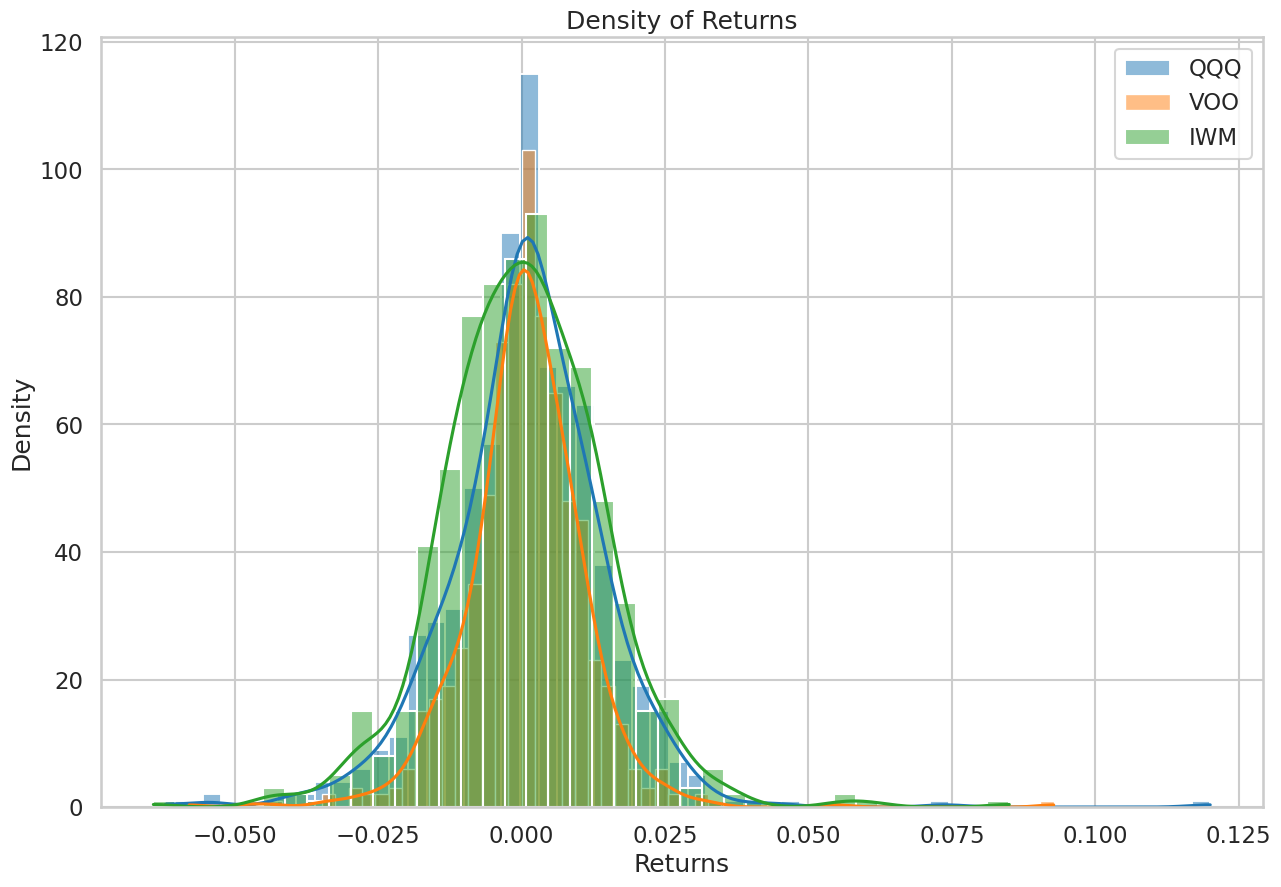

In [34]:
# Hist plot for the returns
sns.set_style('whitegrid')
sns.set_context('talk')
plt.figure(figsize=(15, 10))
sns.histplot(qqq['returns'], label='QQQ', kde=True)
sns.histplot(voo['returns'], label='VOO', kde=True)
sns.histplot(iwm['returns'], label='IWM', kde=True)
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.title('Density of Returns')
plt.show()

In [35]:
# Getting basic stats metrics
df_returns = pd.DataFrame({
    'QQQ': qqq['returns'],
    'VOO': voo['returns'],
    'IWM': iwm['returns']
})

df_log_returns = pd.DataFrame({
    'QQQ': qqq['log_returns'],
    'VOO': voo['log_returns'],
    'IWM': iwm['log_returns']
})

In [36]:
rf_daily = 0.05 / TRADING_DAYS

ann_vol = df_returns.apply(annualized_vol)
sharpe_ratio = df_returns.apply(lambda s: sharpe_ratio(s, rf_daily=rf_daily))
sortino_ratio = df_returns.apply(lambda s: sortino_ratio(s, rf_daily=rf_daily))
skew = df_returns.apply(lambda s: pd.Series(skew_kurtosis(s), index=["skew","excess_kurtosis"])).T

drift_gbm_simple = df_log_returns.apply(annualized_drift_from_log)
ann_returns = df_returns.apply(annualized_return_from_simple)

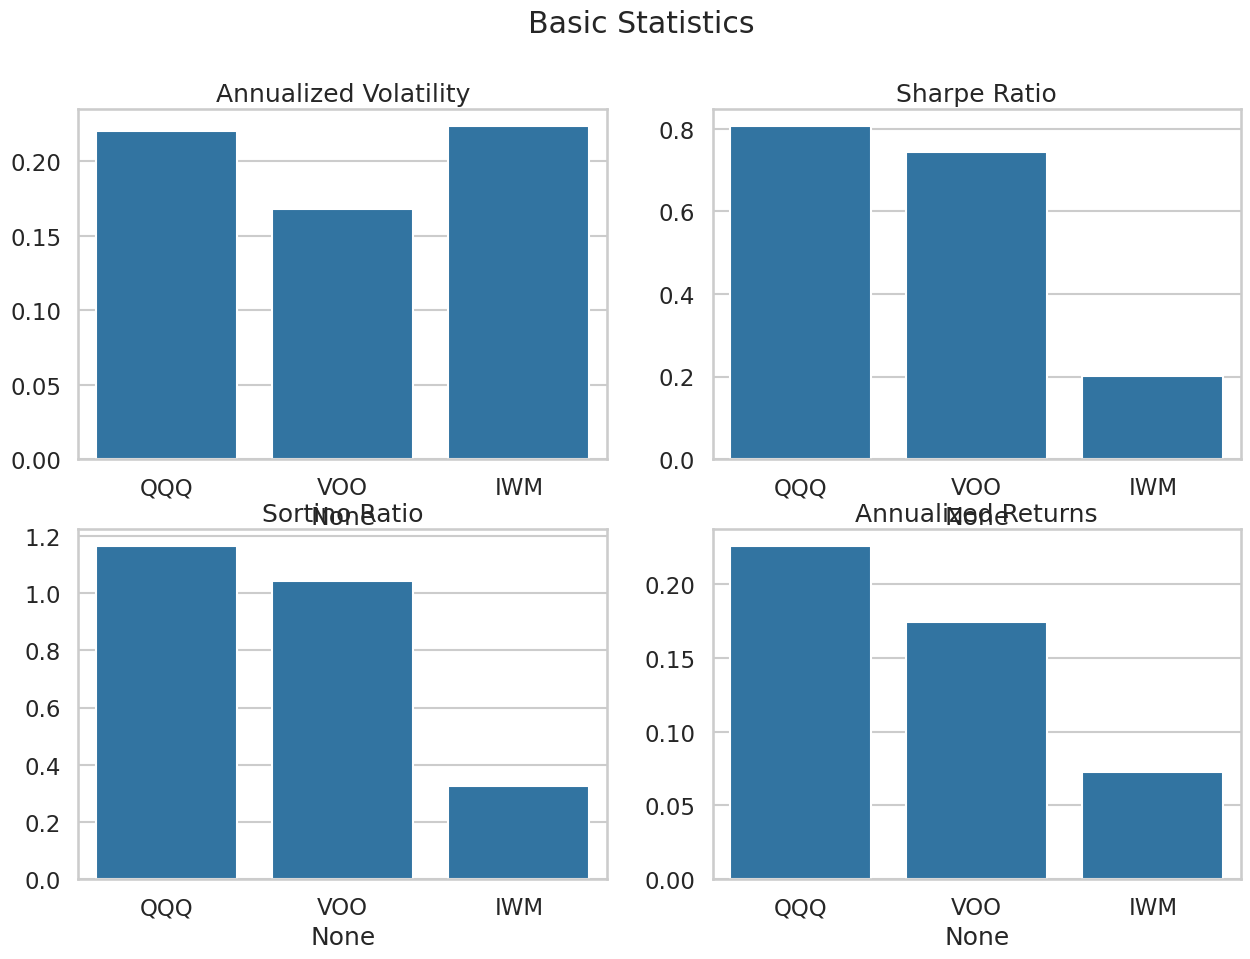

In [37]:
# Bar plot all stats in a multiple slot figure
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Basic Statistics')
sns.barplot(x=ann_vol.index, y=ann_vol.values, ax=axs[0, 0])
axs[0, 0].set_title('Annualized Volatility')
sns.barplot(x=sharpe_ratio.index, y=sharpe_ratio.values, ax=axs[0, 1])
axs[0, 1].set_title('Sharpe Ratio')
sns.barplot(x=sortino_ratio.index, y=sortino_ratio.values, ax=axs[1, 0])
axs[1, 0].set_title('Sortino Ratio')
sns.barplot(x=ann_returns.index, y=ann_returns.values, ax=axs[1, 1])
axs[1, 1].set_title('Annualized Returns')
plt.show()

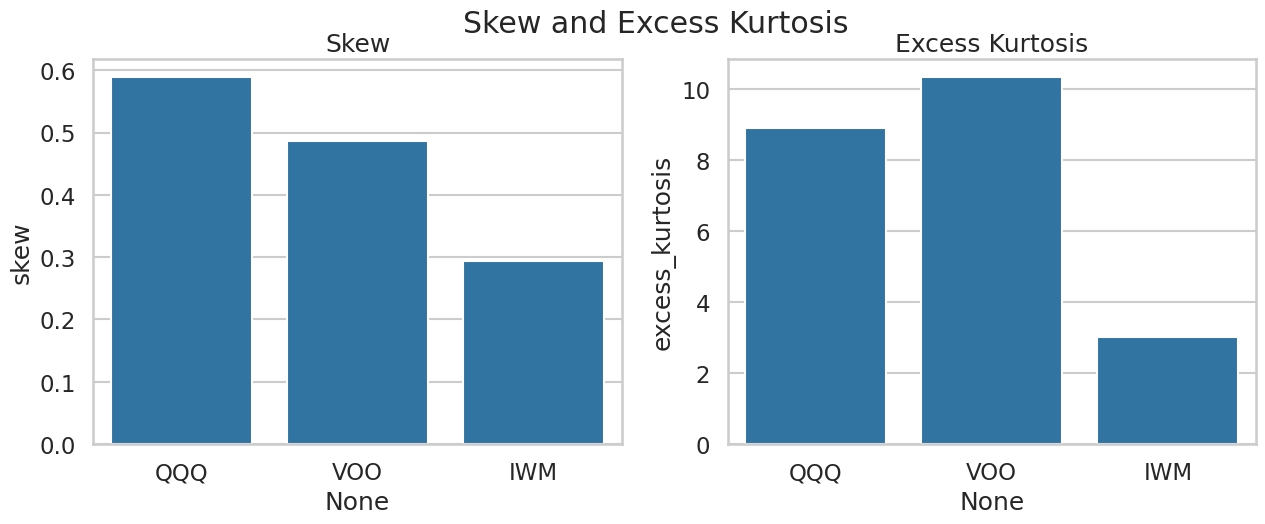

In [38]:
# Bar plot with 2 figures for skew and kurtosis
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Skew and Excess Kurtosis')
sns.barplot(x=skew.index, y=skew['skew'], ax=axs[0])
axs[0].set_title('Skew')
sns.barplot(x=skew.index, y=skew['excess_kurtosis'], ax=axs[1])
axs[1].set_title('Excess Kurtosis')
plt.show()

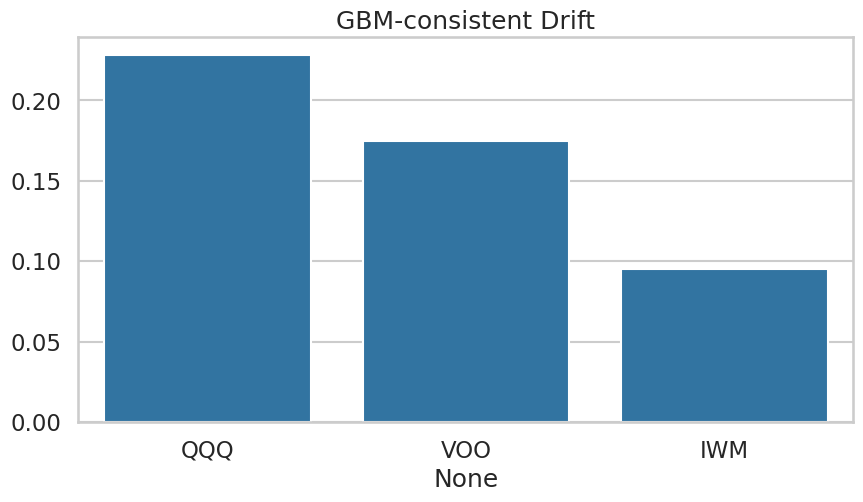

In [39]:
# Barplot for the GBM drift
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=drift_gbm_simple.index, y=drift_gbm_simple.values)
plt.title('GBM-consistent Drift')
plt.show()

## Notes so Far

Looking at the overall statistics based on past performance it looks that QQQ is delivering better returns is it is compared to the risk exposure this stock gives. This alone give some evidence that QQQ is the best candidate within this stock universe. Now to make sure this results are true and to have higher evidence to rejct the null hipothesis, we will run other tests to understand better the this 3 stocks.

## Statistical Test

In this part we will run the following test and models to see if our results are not just a mere coincidence and can actually give us a good indicator for future performance.

---

### Tests

- Augmented Dickey-Fuller (ADF) test
- KPSS test
- Bootstrapping Confidence Intervals
- Jarque-Bera test
- CAPM

In [40]:
# ADF + KPSS test for stationarity data check
def adf_test(s: pd.Series, regression: str = "c"):
    """
    Augmented Dickey-Fuller on returns.
    H0: series has a unit root (non-stationary).
    regression: 'c' (with constant) for level-stationarity; use 'ct' to include trend if needed.
    """
    s = pd.Series(s).dropna()
    stat, pval, lags, nobs, crit, icbest = adfuller(s, autolag="AIC", regression=regression)
    return {"stat": stat, "pval": pval, "lags": lags, "nobs": nobs, "crit": crit, "icbest": icbest}

In [41]:
def kpss_test(s: pd.Series, regression: str = "c", nlags="auto"):
    """
    KPSS on returns.
    H0: series is stationary (around level if 'c', around trend if 'ct').
    """
    s = pd.Series(s).dropna()
    stat, pval, lags, crit = kpss(s, regression=regression, nlags=nlags)
    return {"stat": stat, "pval": pval, "lags": lags, "crit": crit}

In [42]:
def stationarity_report(returns_df: pd.DataFrame, regression: str = "c", alpha: float = 0.05):
    """
    returns_df: columns = tickers, values = DAILY returns (simple or log—either is fine for stationarity).
    regression: 'c' for level-stationarity (typical for returns).
    """
    rows = []
    for col in returns_df.columns:
        s = returns_df[col].dropna()
        # ADF
        adf = adf_test(s, regression=regression)
        adf_decision = "REJECT H0 → Stationary" if adf["pval"] < alpha else "Fail to reject → Non-stationary"
        # KPSS
        k = kpss_test(s, regression=regression, nlags="auto")
        kpss_decision = "Fail to reject H0 → Stationary" if k["pval"] > alpha else "REJECT H0 → Non-stationary"
        rows.append({
            "series": col,
            "ADF_stat": adf["stat"], "ADF_p": adf["pval"], "ADF_lags": adf["lags"], "ADF_decision": adf_decision,
            "KPSS_stat": k["stat"], "KPSS_p": k["pval"], "KPSS_lags": k["lags"], "KPSS_decision": kpss_decision
        })
    out = pd.DataFrame(rows)
    # Optional: nice rounding
    return out.set_index("series").round({"ADF_stat":3,"ADF_p":4,"KPSS_stat":3,"KPSS_p":4})

In [43]:
report = stationarity_report(df_returns, regression="c", alpha=0.05)
report

/tmp/ipython-input-1694834436.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, lags, crit = kpss(s, regression=regression, nlags=nlags)
/tmp/ipython-input-1694834436.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, lags, crit = kpss(s, regression=regression, nlags=nlags)
/tmp/ipython-input-1694834436.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, lags, crit = kpss(s, regression=regression, nlags=nlags)


,ADF_stat,ADF_p,ADF_lags,ADF_decision,KPSS_stat,KPSS_p,KPSS_lags,KPSS_decision
series,,,,,,,,
QQQ,-15.559,0.0,3,REJECT H0 → Stationary,0.065,0.1,13,Fail to reject H0 → Stationary
VOO,-15.790,0.0,3,REJECT H0 → Stationary,0.078,0.1,15,Fail to reject H0 → Stationary
IWM,-27.794,0.0,0,REJECT H0 → Stationary,0.048,0.1,7,Fail to reject H0 → Stationary


### Tests Results

Both ADF and KPSS tests agrees that the data shown is non stationary, which means that our returns does not change over time. Giving more evidence that the data shown is not just coincidence. Now we will check with boostrap to see how it behaves the data over different samples.

In [44]:
def bootstrap_ci(data, func, n_bootstrap=10000, ci=0.95):
    """Bootstrap confidence intervals for a statistic."""
    stats = []
    n = len(data)
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        stats.append(func(sample))
    lower = np.percentile(stats, (1 - ci) / 2 * 100)
    upper = np.percentile(stats, (1 + ci) / 2 * 100)
    return np.mean(stats), (lower, upper)

In [45]:
results = {}
for col in df_returns.columns:
    series = df_returns[col].dropna().values

    mean_est, mean_ci = bootstrap_ci(series, np.mean)
    vol_est, vol_ci = bootstrap_ci(series, np.std)
    sharpe_est, sharpe_ci = bootstrap_ci(series, lambda x: np.mean(x)/np.std(x))

    results[col] = {
        'mean': (mean_est, mean_ci),
        'vol': (vol_est, vol_ci),
        'sharpe': (sharpe_est, sharpe_ci)
    }

results_df = pd.DataFrame(results).T
results_df

,mean,vol,sharpe
QQQ,"(0.0009044024644554647, (-7.367665756335651e-0...","(0.013852100700663079, (0.012432416424803451, ...","(0.06503577479472122, (-0.005944459701971203, ..."
VOO,"(0.0006954144204326508, (-8.190923722786369e-0...","(0.010547747909390236, (0.009382192811134199, ...","(0.06505657532623975, (-0.006398766981502366, ..."
IWM,"(0.00038031891224774256, (-0.00062587685635761...","(0.014065898597733916, (0.013026034269359481, ...","(0.027034005903735385, (-0.045339664183522074,..."


### Test Results

Looking at the results from the test we can see how the QQQ mean is that there is possibility of negative drift but overall high chances of growth. With VOO is narrower the CI meaning more stability. Meanwhile the worst option being IWM with high negative drift over the mean. VOO eventually is the least volatile of 3 and IWM the most volatile. Both VOO and QQQ gives good quality returns for the future performance based on the sharpe ratio.

In [46]:
results = []
for col in ["QQQ", "VOO", "IWM"]:
    stat, p = jarque_bera(df_returns[col].dropna())
    results.append([col, stat, p, "Reject H0 → Not Normal" if p < 0.05 else "Fail to reject H0 → Normal"])

jb_df = pd.DataFrame(results, columns=["Series", "JB_stat", "JB_p", "Decision"])
jb_df

,Series,JB_stat,JB_p,Decision
0,QQQ,2484.11232,0.000000e+00,Reject H0 → Not Normal
1,VOO,3310.63947,0.000000e+00,Reject H0 → Not Normal
2,IWM,290.33152,9.022180e-64,Reject H0 → Not Normal


In [47]:
# Skew and Kurtosis tests
for col in ["QQQ", "VOO", "IWM"]:
    s = skew.loc[col, 'skew']
    k = skew.loc[col, 'excess_kurtosis']
    print(col, "Skew:", s, "Kurtosis:", k)

QQQ Skew: 0.588421259414468 Kurtosis: 8.899236179266174
VOO Skew: 0.48694006584340943 Kurtosis: 10.316395629374128
IWM Skew: 0.294568607612593 Kurtosis: 3.0167619458126875


### Results so Far

Basing on what the tests are telling us, we can say that the data is not normal and means that it has a higher deviation. Looking at the results, there is a string evidence that our results are in fact not random and the stocks moves very close to each other, where IWM has the most steady returns, meaning this returns might not diffireciate in the near future. Meanwhile both QQQ and VOO look more stable and higher expected returns invesment. We have a positive skew on QQQ meaning a higher probability of big upside returns.

## Using Statistical Models

In this part of the notebook we will start modeling our data with different pricing and volatility models to understand more in depth the data and search for actual future insights and start a strategy to invest on QQQ for a lapse of 1 year.

----

### Models

- CAPM
- GBM
- Heston Volatility Model

In [48]:
def to_simple_returns(df: pd.DataFrame, col="returns"):
    """
    Convert a DataFrame with ['date', 'returns', 'log_returns'] into
    ['date','ret'] using the chosen column.
    """
    out = df[["Date", col]].dropna().copy()
    if col == "returns":
        out = out.rename(columns={col: "ret"})
    elif col == "log_returns":
        out["ret"] = np.exp(out[col]) - 1.0
        out = out.drop(columns=[col])
    else:
        raise ValueError("col must be 'returns' or 'log_returns'")
    return out

In [49]:
def build_excess(stock_df, bench_df, rf=None):
    """
    Align by date and compute excess returns: stock - rf, bench - rf.
    rf can be:
      - None (assume 0),
      - scalar daily (e.g., 0.05/252),
      - DataFrame with ['date','ret'].
    Returns DataFrame: ['date','excess_stock','excess_bench'].
    """
    m = stock_df.merge(bench_df, on="Date", how="inner", suffixes=("_s","_b"))
    if rf is None:
        m["rf"] = 0.0
    elif np.isscalar(rf):
        m["rf"] = float(rf)
    else:
        # assume DataFrame with ['date','ret']
        m = m.merge(rf.rename(columns={"ret":"rf"}), on="Date", how="left")
        m["rf"] = m["rf"].fillna(0.0)
    m["excess_stock"] = m["ret_s"] - m["rf"]
    m["excess_bench"] = m["ret_b"] - m["rf"]
    return m[["Date","excess_stock","excess_bench"]].dropna()

In [50]:
def run_capm(excess_df: pd.DataFrame, hac_lags=5, annualize_alpha=True):
    """
    OLS: (R_i - R_f) = alpha + beta*(R_m - R_f) + eps
    Newey–West (HAC) SEs to handle autocorr/het-sked in daily data.
    """
    y = excess_df["excess_stock"]
    X = sm.add_constant(excess_df["excess_bench"])
    res = sm.OLS(y, X, missing="drop").fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})

    alpha_d = res.params["const"]
    beta = res.params["excess_bench"]
    # Annualize alpha via compounding; (approx 252*alpha_d if small)
    alpha_ann = (1 + alpha_d) ** TRADING_DAYS - 1 if annualize_alpha else alpha_d

    return {
        "alpha_daily": alpha_d,
        "alpha_ann": alpha_ann,
        "beta": beta,
        "t_alpha": res.tvalues["const"],
        "p_alpha": res.pvalues["const"],
        "t_beta": res.tvalues["excess_bench"],
        "p_beta": res.pvalues["excess_bench"],
        "r2": res.rsquared,
        "n": int(res.nobs),
        "res": res,
    }

In [51]:
use_col = "returns"          # or "log_returns"
s = to_simple_returns(qqq, col=use_col).rename(columns={"ret":"ret"})
b = to_simple_returns(voo, col=use_col).rename(columns={"ret":"ret"})

In [52]:
rf_daily_scalar = 0.5/252

In [53]:
ex = build_excess(
    stock_df=s.rename(columns={"ret":"ret"}),
    bench_df=b.rename(columns={"ret":"ret"}),
    rf=rf_daily_scalar  # or rf=rf_s
)

In [54]:
capm_out = run_capm(ex, hac_lags=5, annualize_alpha=True)

In [55]:
print(pd.Series({
    "beta": capm_out["beta"],
    "alpha_ann": capm_out["alpha_ann"],
    "t_alpha": capm_out["t_alpha"],
    "p_alpha": capm_out["p_alpha"],
    "t_beta": capm_out["t_beta"],
    "p_beta": capm_out["p_beta"],
    "R2": capm_out["r2"],
    "n": capm_out["n"],
}).round(6))

beta           1.254398
alpha_ann      0.145622
t_alpha        3.350268
p_alpha        0.000807
t_beta        70.038964
p_beta         0.000000
R2             0.912421
n            751.000000
dtype: float64


In [56]:
# For IWM and VOO as benchmark
use_col = "returns"          # or "log_returns"
s = to_simple_returns(iwm, col=use_col).rename(columns={"ret":"ret"})
b = to_simple_returns(voo, col=use_col).rename(columns={"ret":"ret"})

In [57]:
ex = build_excess(
    stock_df=s.rename(columns={"ret":"ret"}),
    bench_df=b.rename(columns={"ret":"ret"}),
    rf=rf_daily_scalar  # or rf=rf_s
)

In [58]:
capm_out = run_capm(ex, hac_lags=5, annualize_alpha=True)

In [59]:
print(pd.Series({
    "beta": capm_out["beta"],
    "alpha_ann": capm_out["alpha_ann"],
    "t_alpha": capm_out["t_alpha"],
    "p_alpha": capm_out["p_alpha"],
    "t_beta": capm_out["t_beta"],
    "p_beta": capm_out["p_beta"],
    "R2": capm_out["r2"],
    "n": capm_out["n"],
}).round(6))

beta           1.120755
alpha_ann     -0.039743
t_alpha       -0.570030
p_alpha        0.568658
t_beta        32.483808
p_beta         0.000000
R2             0.707515
n            751.000000
dtype: float64


  Stock      Beta  Alpha_ann   t_alpha   p_alpha     t_beta         p_beta  \
0   QQQ  1.254398   0.021506  0.567772  0.570360  88.335944   0.000000e+00   
1   IWM  1.120755  -0.094891 -1.351113  0.177067  42.565467  3.935471e-202   

         R2  
0  0.912421  
1  0.707515  


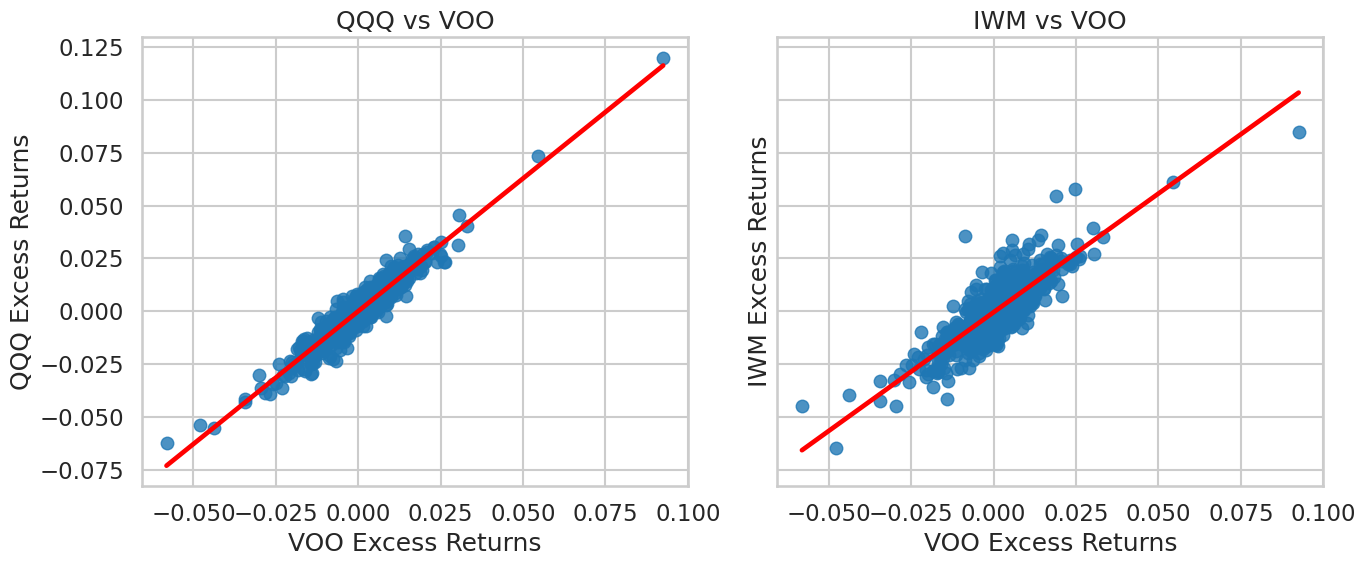

In [60]:
rf = 0.05/252
rets = df_returns[['QQQ','IWM','VOO']] - rf

results = []

for stock in ['QQQ','IWM']:
    Y = rets[stock].dropna() # Drop NaNs from the dependent variable
    X = sm.add_constant(rets['VOO'].dropna())   # VOO as benchmark, drop NaNs

    # Align the indices of X and Y after dropping NaNs
    aligned_X, aligned_Y = X.align(Y, join='inner', axis=0)

    model = sm.OLS(aligned_Y, aligned_X).fit()

    alpha = model.params['const']
    beta = model.params['VOO']

    # Annualize alpha assuming ~252 trading days
    alpha_ann = alpha * 252

    results.append({
        'Stock': stock,
        'Beta': beta,
        'Alpha_ann': alpha_ann,
        't_alpha': model.tvalues['const'],
        'p_alpha': model.pvalues['const'],
        't_beta': model.tvalues['VOO'],
        'p_beta': model.pvalues['VOO'],
        'R2': model.rsquared
    })

capm_df = pd.DataFrame(results)
print(capm_df)

# --------------------
# Scatter plots
# --------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

for i, stock in enumerate(['QQQ','IWM']):
    Y = rets[stock].dropna()
    X = rets['VOO'].dropna()
    # Align the indices of X and Y for plotting
    aligned_X, aligned_Y = X.align(Y, join='inner', axis=0)
    sns.regplot(x=aligned_X, y=aligned_Y, ci=None, line_kws={"color":"red"}, ax=axes[i])
    axes[i].set_title(f"{stock} vs VOO")
    axes[i].set_xlabel("VOO Excess Returns")
    axes[i].set_ylabel(f"{stock} Excess Returns")

plt.tight_layout()
plt.show()

### Looking at the Results

Looking at the results of the CAPM we can say that the QQQ with 95 confidence will outperform the market by 14.7%. Given this results it means if we properly hadnle risk with QQQ due to higher volatility, we can actually outperform the market by 14.7% with a confidence of 95%.

In [61]:
def heston_sim(S0, v0, mu, kappa, theta, xi, rho, T=1, N=252, M=1000):
    dt = T/N
    S = np.zeros((N+1, M))
    v = np.zeros((N+1, M))
    S[0] = S0
    v[0] = v0

    for t in range(1, N+1):
        z1 = np.random.standard_normal(M)
        z2 = np.random.standard_normal(M)
        z2 = rho*z1 + np.sqrt(1-rho**2)*z2  # correlate

        v[t] = np.abs(v[t-1] + kappa*(theta-v[t-1])*dt + xi*np.sqrt(v[t-1]*dt)*z2)
        S[t] = S[t-1] * np.exp((mu-0.5*v[t-1])*dt + np.sqrt(v[t-1]*dt)*z1)

    return S, v

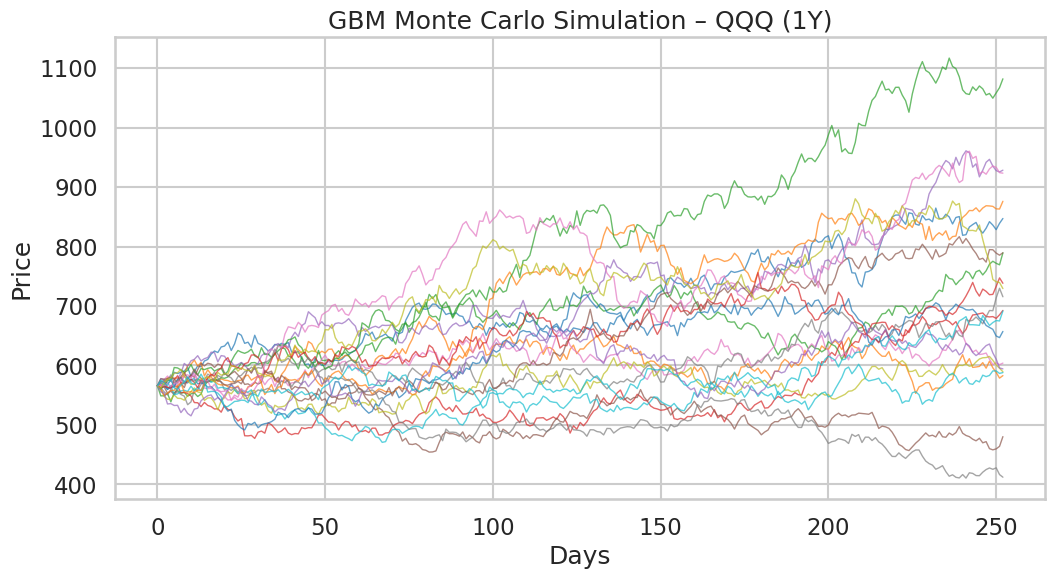

In [62]:
#GBM for QQQ
S0 = qqq['close'].iloc[-1]

# annualized drift and vol (using log returns!)
mu = rets['QQQ'].mean() * 252
sigma = rets['QQQ'].std() * np.sqrt(252)

T = 1
dt = 1/252
N = int(T/dt)
M = 1000

paths = np.zeros((N+1, M))
paths[0] = S0

for t in range(1, N+1):
    z = np.random.standard_normal(M)
    paths[t] = paths[t-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z)

plt.figure(figsize=(12,6))
plt.plot(paths[:, :20], lw=1, alpha=0.7)
plt.title("GBM Monte Carlo Simulation – QQQ (1Y)")#
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()

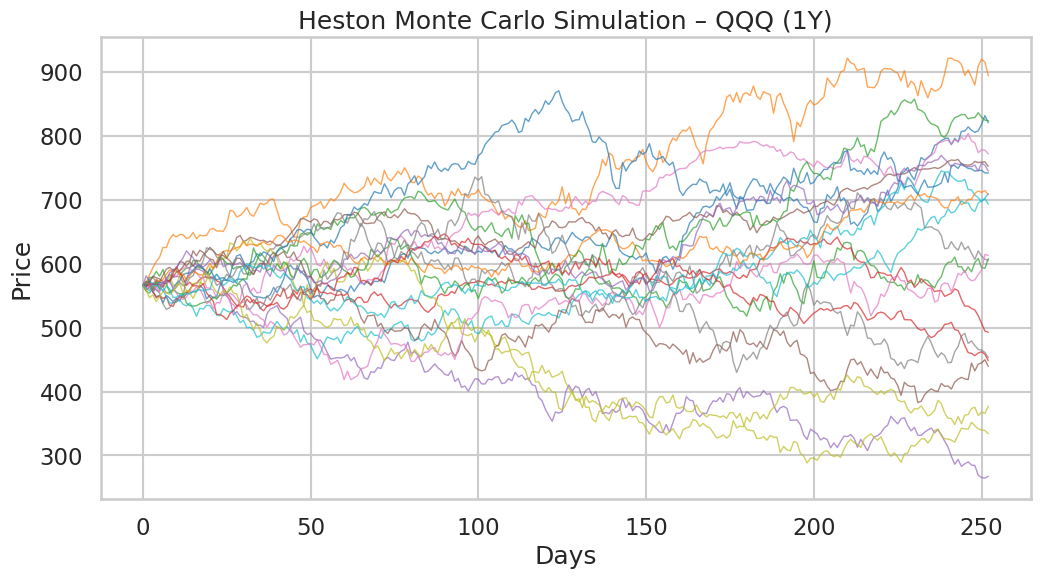

In [63]:
v0 = sigma**2
kappa = 2.0
theta = v0
xi = 0.3
rho = -0.7

S, v = heston_sim(S0, v0, mu, kappa, theta, xi, rho)

# Plot
plt.figure(figsize=(12,6))
plt.plot(S[:, :20], lw=1, alpha=0.7)
plt.title("Heston Monte Carlo Simulation – QQQ (1Y)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()

In [64]:
# Looking at both simulations based on the mean path
gbm_mean_path   = paths.mean(axis=1)           # E[S_t]
gbm_median_path = np.median(paths, axis=1)     # 50th percentile

hes_mean_path   = S.mean(axis=1)
hes_median_path = np.median(S, axis=1)

In [65]:
def bands(paths, ps=(5,25,75,95)):
    return {p: np.percentile(paths, p, axis=1) for p in ps}

gbm_b = bands(paths)
hes_b = bands(S)

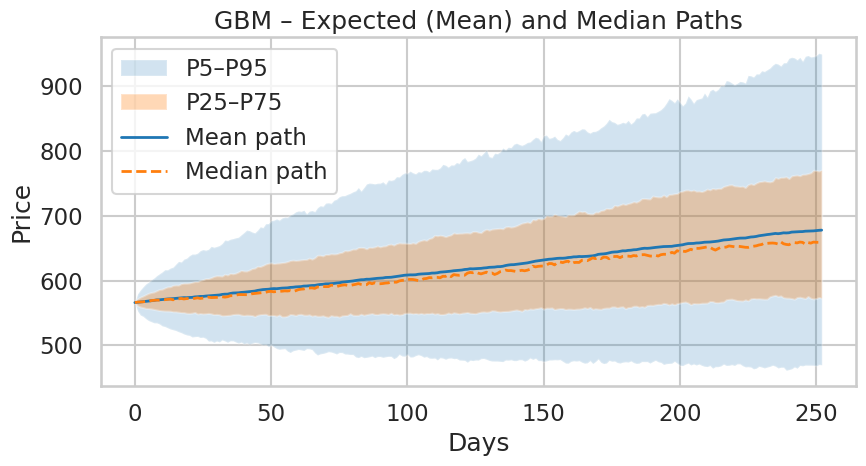

In [66]:
# Plot GBM
plt.figure(figsize=(9,5))
plt.fill_between(np.arange(len(gbm_b[5])), gbm_b[5], gbm_b[95], alpha=0.2, label="P5–P95")
plt.fill_between(np.arange(len(gbm_b[25])), gbm_b[25], gbm_b[75], alpha=0.3, label="P25–P75")
plt.plot(gbm_mean_path, linewidth=2, label="Mean path")
plt.plot(gbm_median_path, linewidth=2, linestyle="--", label="Median path")
plt.title("GBM – Expected (Mean) and Median Paths")
plt.xlabel("Days"); plt.ylabel("Price"); plt.legend(); plt.tight_layout(); plt.show()

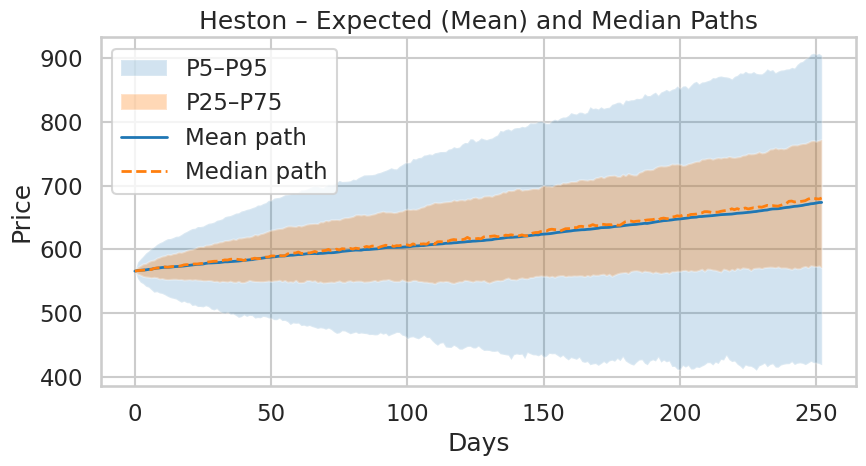

In [67]:
plt.figure(figsize=(9,5))
plt.fill_between(np.arange(len(hes_b[5])), hes_b[5], hes_b[95], alpha=0.2, label="P5–P95")
plt.fill_between(np.arange(len(hes_b[25])), hes_b[25], hes_b[75], alpha=0.3, label="P25–P75")
plt.plot(hes_mean_path, linewidth=2, label="Mean path")
plt.plot(hes_median_path, linewidth=2, linestyle="--", label="Median path")
plt.title("Heston – Expected (Mean) and Median Paths")
plt.xlabel("Days"); plt.ylabel("Price"); plt.legend(); plt.tight_layout(); plt.show()

In [68]:
def describe(x):
    q = np.quantile(x, [0.01,0.05,0.25,0.5,0.75,0.95,0.99])
    return {
        "mean": np.mean(x),
        "median": q[3],
        "p1": q[0], "p5": q[1], "p25": q[2],
        "p75": q[4], "p95": q[5], "p99": q[6]
    }

In [69]:
gbm_ret = gbm_mean_path / S0 - 1.0
hes_ret = hes_mean_path / S0 - 1.0

In [70]:
C = 1_000_000.0
gbm_wealth = C * (1 + gbm_ret)
hes_wealth = C * (1 + hes_ret)

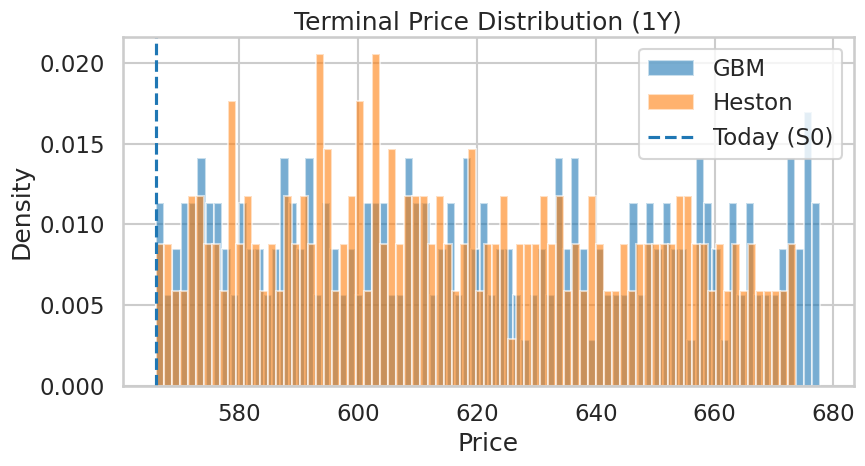

PRICE stats
GBM   : {'mean': np.float64(620.7750372812483), 'median': np.float64(618.5429109433578), 'p1': np.float64(566.9646892228211), 'p5': np.float64(571.5843151953819), 'p25': np.float64(591.5149137734903), 'p75': np.float64(650.022746489916), 'p95': np.float64(673.6704442366045), 'p99': np.float64(676.8680366914713)}
Heston: {'mean': np.float64(616.7964682190604), 'median': np.float64(613.425620680898), 'p1': np.float64(567.4344586516876), 'p5': np.float64(572.096582893648), 'p25': np.float64(593.0854290746007), 'p75': np.float64(641.4861544666677), 'p95': np.float64(665.8617299698171), 'p99': np.float64(672.3029078186229)}



In [71]:
plt.figure(figsize=(9,5))
plt.hist(gbm_mean_path, bins=80, density=True, alpha=0.6, label="GBM")
plt.hist(hes_mean_path, bins=80, density=True, alpha=0.6, label="Heston")
plt.axvline(S0, linestyle="--", label="Today (S0)")
plt.title("Terminal Price Distribution (1Y)")
plt.xlabel("Price"); plt.ylabel("Density"); plt.legend(); plt.tight_layout(); plt.show()

print("PRICE stats")
print("GBM   :", describe(gbm_mean_path))
print("Heston:", describe(hes_mean_path))
print()

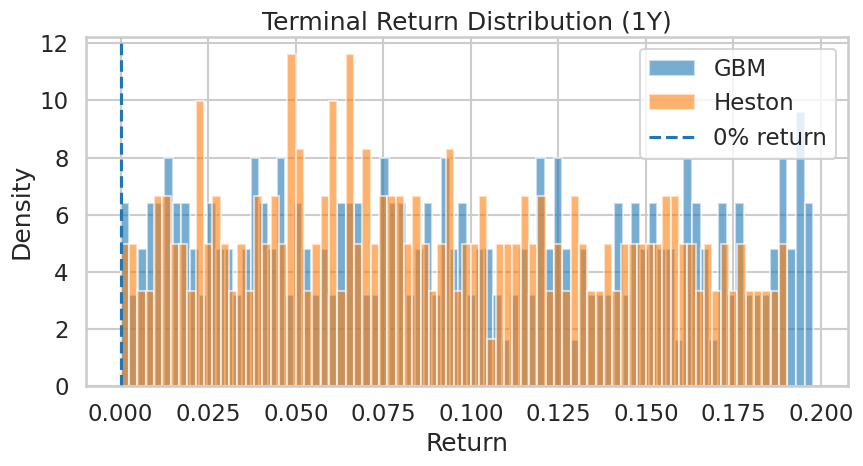

RETURN stats
GBM   : {'mean': np.float64(0.09696944778188311), 'median': np.float64(0.09302506495524931), 'p1': np.float64(0.0018813655466103807), 'p5': np.float64(0.01004469082185504), 'p25': np.float64(0.045263983485333226), 'p75': np.float64(0.1486529748129184), 'p95': np.float64(0.19044074071940245), 'p99': np.float64(0.19609119542326559)}
Heston: {'mean': np.float64(0.08993893198307709), 'median': np.float64(0.0839823188133697), 'p1': np.float64(0.00271149349960492), 'p5': np.float64(0.01094991732152959), 'p25': np.float64(0.04803923570896851), 'p75': np.float64(0.133567992210051), 'p95': np.float64(0.1766419884135112), 'p99': np.float64(0.1880241717867584)}



In [72]:
plt.figure(figsize=(9,5))
plt.hist(gbm_ret, bins=80, density=True, alpha=0.6, label="GBM")
plt.hist(hes_ret, bins=80, density=True, alpha=0.6, label="Heston")
plt.axvline(0.0, linestyle="--", label="0% return")
plt.title("Terminal Return Distribution (1Y)")
plt.xlabel("Return"); plt.ylabel("Density"); plt.legend(); plt.tight_layout(); plt.show()

print("RETURN stats")
print("GBM   :", describe(gbm_ret))
print("Heston:", describe(hes_ret))
print()

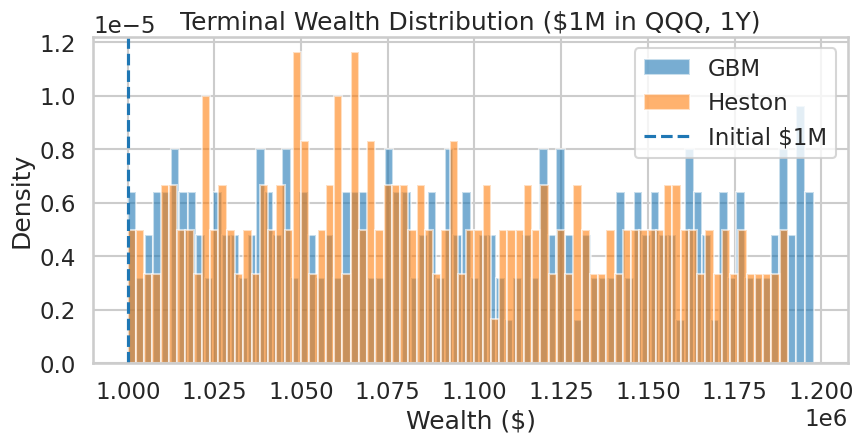

WEALTH stats ($)
GBM   : {'mean': np.float64(1096969.4477818832), 'median': np.float64(1093025.0649552494), 'p1': np.float64(1001881.3655466104), 'p5': np.float64(1010044.6908218551), 'p25': np.float64(1045263.9834853333), 'p75': np.float64(1148652.9748129183), 'p95': np.float64(1190440.7407194024), 'p99': np.float64(1196091.1954232657)}
Heston: {'mean': np.float64(1089938.9319830772), 'median': np.float64(1083982.3188133696), 'p1': np.float64(1002711.4934996049), 'p5': np.float64(1010949.9173215296), 'p25': np.float64(1048039.2357089685), 'p75': np.float64(1133567.992210051), 'p95': np.float64(1176641.9884135113), 'p99': np.float64(1188024.1717867584)}



In [73]:
plt.figure(figsize=(9,5))
plt.hist(gbm_wealth, bins=80, density=True, alpha=0.6, label="GBM")
plt.hist(hes_wealth, bins=80, density=True, alpha=0.6, label="Heston")
plt.axvline(C, linestyle="--", label="Initial $1M")
plt.title("Terminal Wealth Distribution ($1M in QQQ, 1Y)")
plt.xlabel("Wealth ($)"); plt.ylabel("Density"); plt.legend(); plt.tight_layout(); plt.show()

print("WEALTH stats ($)")
print("GBM   :", describe(gbm_wealth))
print("Heston:", describe(hes_wealth))
print()

In [74]:
prob_loss_gbm = (gbm_mean_path < S0).mean()
prob_loss_hes = (hes_mean_path < S0).mean()
print(f"Prob(end below today): GBM={prob_loss_gbm}, Heston={prob_loss_hes}")

Prob(end below today): GBM=0.0, Heston=0.0


In [75]:
prob_loss_gbm = (paths[-1] < S0).mean()
prob_loss_hes = (S[-1] < S0).mean()
print(f"Prob(end below today): GBM={prob_loss_gbm:.3f}, Heston={prob_loss_hes:.3f}")

Prob(end below today): GBM=0.231, Heston=0.234


## Results and Next Steps

Based on our results we are most probably risking around 21.3%~23.3% of our capital. What this means that we need to create a strategy that hedges this possible risk amount in such a way we end up with a minimal risk strategy to enter the market in QQQ which is is the best possible option for higher returns and possibly genereting Alpha over the course of 1 year.

## Strategy

To properly invest into QQQ for 1 year we need to maximize our returns while avoiding the risk of loosing part of the capital. For this a buy and hold by default can give us 14.7% more of alpha, we need to use a strategy that not only protects from drawndowns but also enters again the market with more favorable conditions.

In [88]:
def as_table(model_name, wealth, alpha=0.05, C=1_000_000):
    losses = C - wealth
    var_alpha = np.percentile(losses, alpha*100)
    cvar_alpha = losses[losses >= var_alpha].mean()

    return {
        "model": model_name,
        f"VaR$ ({int(alpha*100)}%)": var_alpha,
        f"CVaR$ ({int(alpha*100)}%)": cvar_alpha,
        f"VaR% ({int(alpha*100)}%)": var_alpha / C,
        f"CVaR% ({int(alpha*100)}%)": cvar_alpha / C
    }

In [101]:
def var_cvar_from_wealth(wealth: np.ndarray,
                         initial_capital: float = 1_000_000.0,
                         alpha: float = 0.05):
    """
    Compute Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR)
    from simulated terminal wealth values.

    Parameters
    ----------
    wealth : np.ndarray
        Array of simulated terminal wealth outcomes.
    initial_capital : float, default=1_000_000.0
        Initial portfolio value.
    alpha : float, default=0.05
        Tail probability (e.g., 0.05 = 5%).

    Returns
    -------
    var_alpha : float
        Value-at-Risk at level alpha (expected minimum loss).
    cvar_alpha : float
        Conditional VaR (expected loss given loss exceeds VaR).
    w_alpha : float
        Wealth quantile at alpha (5th percentile wealth).
    """
    # alpha-quantile of terminal wealth
    w_alpha = np.quantile(wealth, alpha)

    # VaR: shortfall compared to initial capital
    var_alpha = max(0.0, initial_capital - w_alpha)

    # CVaR: average shortfall in worst alpha% scenarios
    tail_losses = initial_capital - wealth[wealth <= w_alpha]
    cvar_alpha = tail_losses.mean() if tail_losses.size > 0 else 0.0

    return var_alpha, cvar_alpha, w_alpha

In [102]:
def summarize_var_cvar(label: str,
                       wealth: np.ndarray,
                       initial_capital: float = 1_000_000.0,
                       alpha: float = 0.05):
    """
    Summarize VaR and CVaR metrics for a given wealth distribution.

    Parameters
    ----------
    label : str
        Model label (e.g., "GBM" or "Heston").
    wealth : np.ndarray
        Array of simulated terminal wealth outcomes.
    initial_capital : float, default=1_000_000.0
        Initial portfolio value.
    alpha : float, default=0.05
        Tail probability.

    Returns
    -------
    summary : dict
        Dictionary with metrics: prob_loss, wealth p5, VaR$, CVaR$,
        VaR%, CVaR%, and w_alpha.
    """
    var_alpha, cvar_alpha, w_alpha = var_cvar_from_wealth(
        wealth, initial_capital, alpha
    )

    return {
        "model": label,
        "prob_loss": float((wealth < initial_capital).mean()),
        "Wealth p5": float(w_alpha),
        "VaR$ (5%)": float(var_alpha),
        "CVaR$ (5%)": float(cvar_alpha),
        "VaR% (5%)": float(var_alpha / initial_capital),
        "CVaR% (5%)": float(cvar_alpha / initial_capital),
        "W_alpha": float(w_alpha),
    }

In [103]:
S0 = float(S0)
C  = 1_000_000.0

gbm_term = paths[-1]
hes_term = S[-1]

# Convert terminal prices -> terminal wealth on $C
gbm_wealth = C * (gbm_term / S0)
hes_wealth = C * (hes_term / S0)

In [104]:
out = pd.DataFrame([
    as_table("GBM", gbm_wealth, alpha=0.05, C=C),
    as_table("Heston", hes_wealth, alpha=0.05, C=C),
])

In [105]:
fmt = out.copy()
fmt["VaR$ (5%)"] = fmt["VaR$ (5%)"].map(lambda x: f"${x:,.0f}")
fmt["CVaR$ (5%)"] = fmt["CVaR$ (5%)"].map(lambda x: f"${x:,.0f}")
fmt["VaR% (5%)"] = fmt["VaR% (5%)"].map(lambda x: f"{100*x:.2f}%")
fmt["CVaR% (5%)"] = fmt["CVaR% (5%)"].map(lambda x: f"{100*x:.2f}%")
print(fmt)

    model  VaR$ (5%) CVaR$ (5%) VaR% (5%) CVaR% (5%)
0     GBM  $-678,267  $-164,634   -67.83%    -16.46%
1  Heston  $-597,860  $-162,410   -59.79%    -16.24%


In [107]:
summary = pd.DataFrame([
    summarize_var_cvar("GBM", gbm_wealth, initial_capital=C, alpha=0.0),
    summarize_var_cvar("Heston", hes_wealth, initial_capital=C, alpha=0.0),
])

In [108]:
summary

,model,prob_loss,Wealth p5,VaR$ (5%),CVaR$ (5%),VaR% (5%),CVaR% (5%),W_alpha
0,GBM,0.231,497490.171300,502509.828700,502509.828700,0.502510,0.502510,497490.171300
1,Heston,0.234,372484.380732,627515.619268,627515.619268,0.627516,0.627516,372484.380732


In [109]:
# Plloting the losses
gbm_var, gbm_cvar, gbm_walpha = var_cvar_from_wealth(gbm_wealth, initial_capital=C, alpha=0.05)
hes_var, hes_cvar, hes_walpha = var_cvar_from_wealth(hes_wealth, initial_capital=C, alpha=0.05)

In [110]:
gbm_losses = np.maximum(0.0, C - gbm_wealth)
hes_losses = np.maximum(0.0, C - hes_wealth)

In [111]:
def plot_loss_distribution(losses, var_value, cvar_value, title):
    plt.figure(figsize=(9,5))
    # Histogram of losses
    plt.hist(losses, bins=100, density=True, alpha=0.7)
    # VaR line
    plt.axvline(var_value, linestyle="--", linewidth=2, label=f"VaR 5% = ${var_value:,.0f}")
    # Shade CVaR tail (losses >= VaR)
    tail_mask = losses >= var_value
    if tail_mask.any():
        tail_vals = losses[tail_mask]
        # Shade by plotting a filled histogram region for the tail
        plt.hist(tail_vals, bins=50, density=True, alpha=0.4, label=f"Tail (for CVaR): ${cvar_value:,.0f} avg")
    plt.title(title)
    plt.xlabel("Loss ($)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

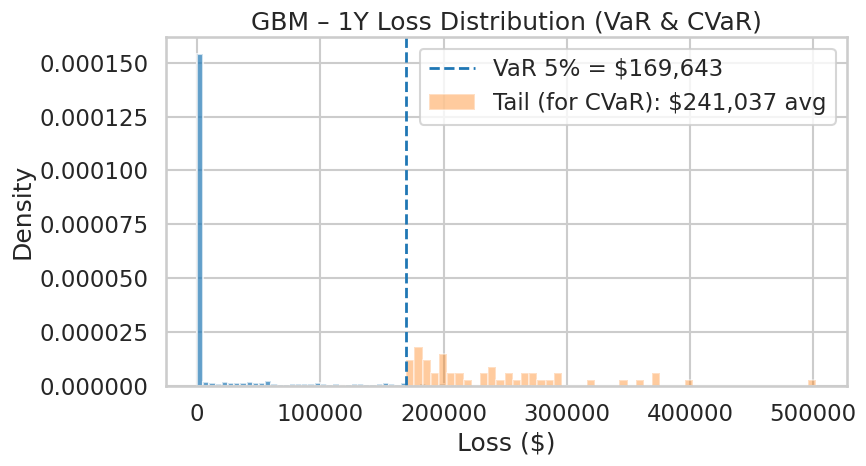

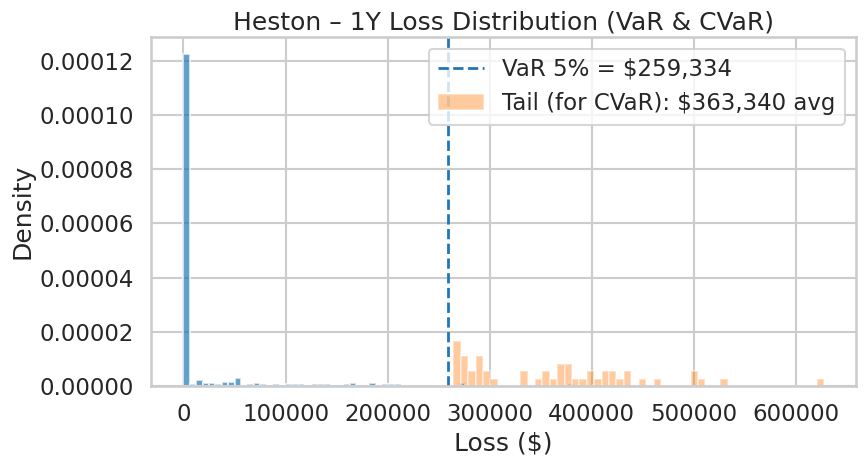

In [112]:
plot_loss_distribution(gbm_losses, gbm_var, gbm_cvar, "GBM – 1Y Loss Distribution (VaR & CVaR)")
plot_loss_distribution(hes_losses, hes_var, hes_cvar, "Heston – 1Y Loss Distribution (VaR & CVaR)")

## Stategy Design

based on the results we can conclude that the likelyhood of negative returns at
5% percent is about 23 over 1 year, as a result based on Heston simulation we can see how biggger is the difference between the possible looses. On average 5% of the cases losses around 259,334. Based solely on this results we need to find the right strategy to trade the QQQ avoiding this potential losses, where a buy and hold has the potential of lossing around 363,340`$` of a 1,000,000$ invesment

## Protective Collar Strategy — QQQ Exposure

----
### Objective
We design and test a **protective collar strategy** on QQQ exposure to
mitigate tail risk (as seen in Heston simulations) while preserving
equity upside.

- Long QQQ (underlying exposure)
- Long OTM put (downside protection)
- Short OTM call (financing the put)
- Rolled quarterly

We compare distributions, VaR/CVaR, and drawdowns to buy-and-hold.

# Conclusions

Based on the analysis of the stock we can derive that QQ is the best option for higher returns and measured risk. Looking more in depth into the risk porpotions of QQQ we find that over the lapse of 1 year there is a 5% chance of loosing around 300,000$ in the stock. For this we decided that the best strategy for this case is the most known protective collar to hedge the loose risk in the stock.